# Moyenne multi-modèle sur la période d'observation suivant les différentes méthodes

In [133]:
from watermark import watermark
%load_ext watermark
print(watermark())

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-05T08:29:11.307718+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [134]:
import xarray as xr
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
from skimage.measure import find_contours
import matplotlib.colors as mcolors
import os
import calendar

In [135]:
%watermark --iversions

xarray    : 2025.1.1
cartopy   : 0.24.0
matplotlib: 3.10.0
numpy     : 2.0.2
skimage   : 0.25.0
watermark : 2.5.0
pandas    : 2.2.3



## Fichiers historiques

In [197]:
def get_data(path_snc, path_areacella, path_sftlf):
    ds_snc = xr.open_dataset(path_snc)
    ds_area = xr.open_dataset(path_areacella)
    ds_sftlf = xr.open_dataset(path_sftlf)
    return ds_snc, ds_area, ds_sftlf

def extraction_variable_and_monthly_mean(ds_snc, variable="snc", start_year="1995", end_year="2014", lat_min=20):
    snc = ds_snc[variable].sel(time=slice(start_year, end_year))

    if lat_min is not None:
        snc = snc.sel(lat=snc.lat >= lat_min)

    snc = snc.where(snc < 1e19, float("nan"))

    max_val = snc.max().item()
    if max_val > 1.5:
        print(f"La variable '{variable}' est en %. Conversion en fraction.")
        snc = snc / 100

    if sftlf is not None:
        snc=snc.where(sftlf>0)

    snc = snc.clip(0, 1)

    snow_cover = snc.groupby("time.month").mean(dim="time")
    monthly_mean = snow_cover.mean(dim=("lat", "lon"))

    return snc, snow_cover, monthly_mean

def snow_surface_calculation(snow_cover, areacella):
    area_km2 = areacella * 1e-6
    snow_cover_km2 = (snow_cover * area_km2).groupby(snow_cover["month"]).sum(dim=["lat", "lon"], skipna=True)
    return snow_cover_km2

#def plot_snow_cover_initial(snc, time_index=0, title="Carte couverture neigeuse"):
    #plt.figure(figsize=(10, 5))
    #ax = plt.axes(projection=ccrs.PlateCarree())
    #snc.isel(time=time_index).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    #ax.coastlines()
    #plt.title(title)
    #plt.show()

def plot_snow_cover_initial(snc, time_index=0, title="Carte couverture neigeuse", ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.axes(projection=ccrs.PlateCarree())
        show_plot = True
    else:
        show_plot = False
        
    snc.isel(time=time_index).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    ax.set_title(title)

    if show_plot:
        plt.show

def plot_monthly_mean(monthly_mean, xlabel="Mois", ylabel="Average Snow Cover", title="Monthly average snow cover"):
    plt.plot(range(1, 13), monthly_mean, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

def plot_surface_km2(snow_cover_km2, xlabel="Mois", ylabel="Snowy surface (km2)", title="Average monthly snow cover area"):
    plt.plot(range(1, 13), snow_cover_km2, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

In [198]:
files = os.listdir("/home/jovyan/private-storage/interp_models_hist_bis/")

nc_files = [filename for filename in files if filename.endswith(".nc")]
nc_files

['IPSL-CM6A-LR_hist_reprojete.nc',
 'BCC-CSM2-MR_hist_reprojete.nc',
 'CanESM5_hist_reprojete.nc',
 'CanESM5-CanOE_hist_reprojete.nc',
 'CESM2_hist_reprojete.nc',
 'CESM2-WACCM_hist_reprojete.nc',
 'CIESM_hist_reprojete.nc',
 'CNRM-CM6-1_hist_reprojete.nc',
 'CNRM-CM6-1-HR_hist_reprojete.nc',
 'CNRM-ESM2-1_hist_reprojete.nc',
 'EC-Earth3_hist_reprojete.nc',
 'EC-Earth3-Veg_hist_reprojete.nc',
 'FGOALS-f3-L_hist_reprojete.nc',
 'FGOALS-g3_hist_reprojete.nc',
 'GFDL-CM4_hist_reprojete.nc',
 'GISS-E2-1-G_hist_reprojete.nc',
 'HadGEM3-GC31-LL_hist_reprojete.nc',
 'MIROC-ES2L_hist_reprojete.nc',
 'MIROC6_hist_reprojete.nc',
 'MPI-ESM1-2-HR_hist_reprojete.nc',
 'MPI-ESM1-2-LR_hist_reprojete.nc',
 'MRI-ESM2-0_hist_reprojete.nc',
 'NorESM2-LM_hist_reprojete.nc',
 'NorESM2-MM_hist_reprojete.nc',
 'UKESM1-0-LL_hist_reprojete.nc']

## Snow reference

In [199]:
path_snow_ref = os.path.join("~/private-storage/output_data/", "snow_reference.nc")

In [200]:
snow_ref = xr.open_dataset(path_snow_ref)

In [201]:
snow_ref = snow_ref["snow_cover_extent"]
snow_ref

<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 180, lon: 360)> Size: 3MB
[777600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  surface_snow_binary_mask
    long_name:      NOAA/NCEI Climate Data Record of snow cover extent
    cell_methods:   time: mean
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered

In [202]:
path = "/home/jovyan/private-storage/grid/"
file = "area.nc"
area = xr.open_dataset(os.path.join(path, file))

In [203]:
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [204]:
seasonal_snow_reference = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = snow_ref.sel(month=months_float)
    seasonal_snow_reference[season] = da_sel.mean(dim="month", skipna=True)

In [205]:
djf_snow_reference = seasonal_snow_reference['DJF']
mam_snow_reference = seasonal_snow_reference['MAM']
jja_snow_reference = seasonal_snow_reference['JJA']
son_snow_reference = seasonal_snow_reference['SON']

## Utilisation des fonctions

La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.


/tmp/ipykernel_83/1381132720.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.


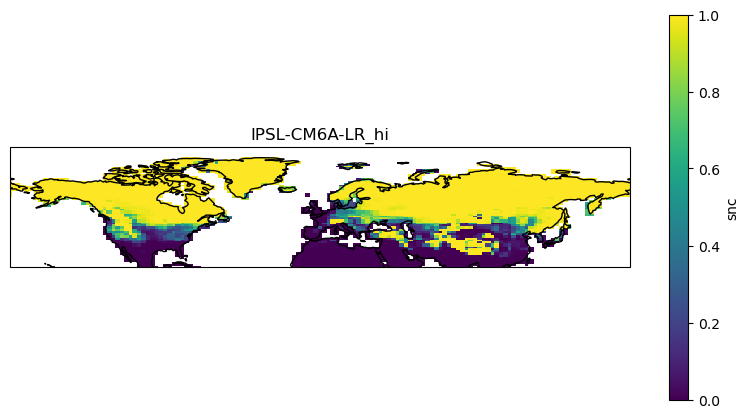

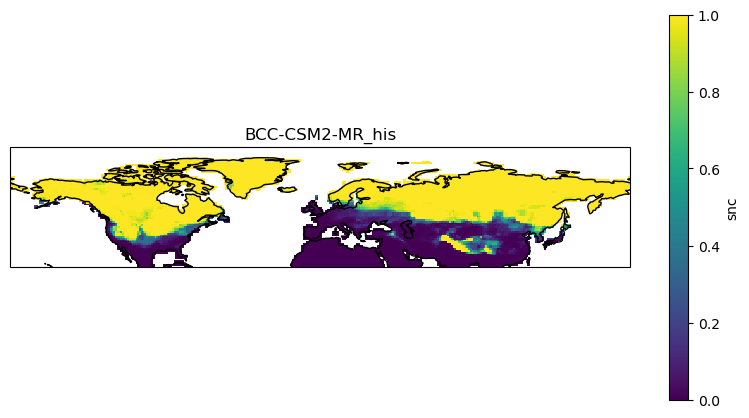

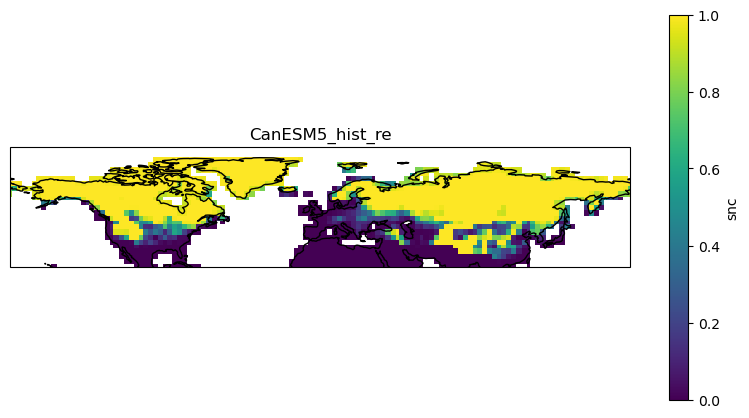

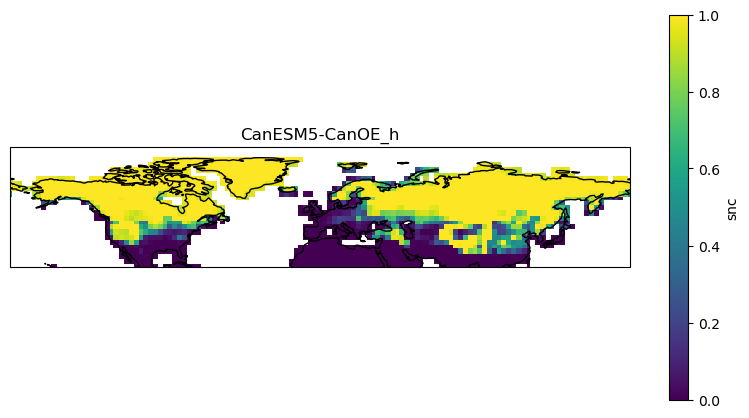

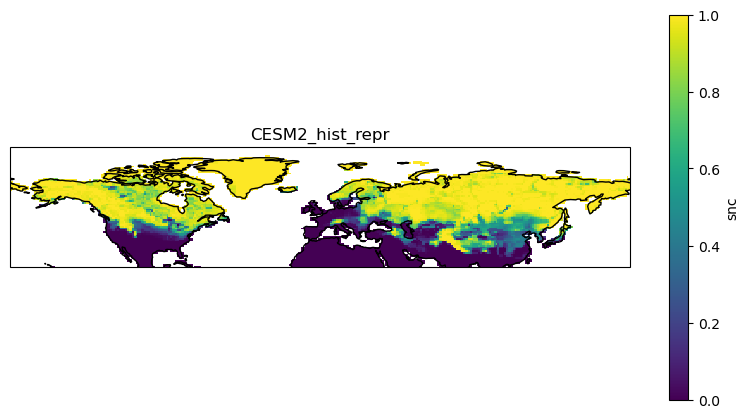

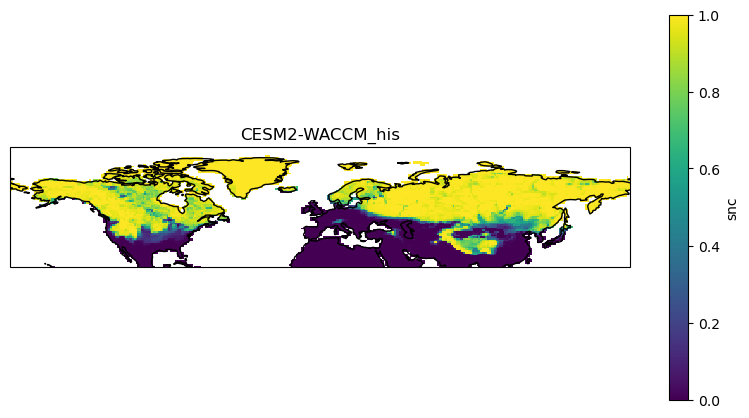

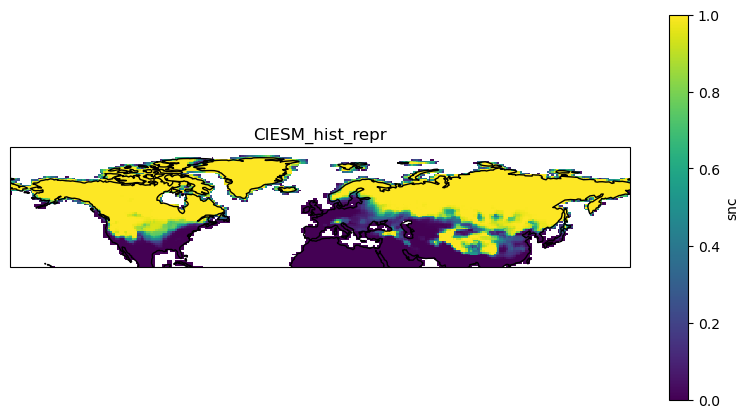

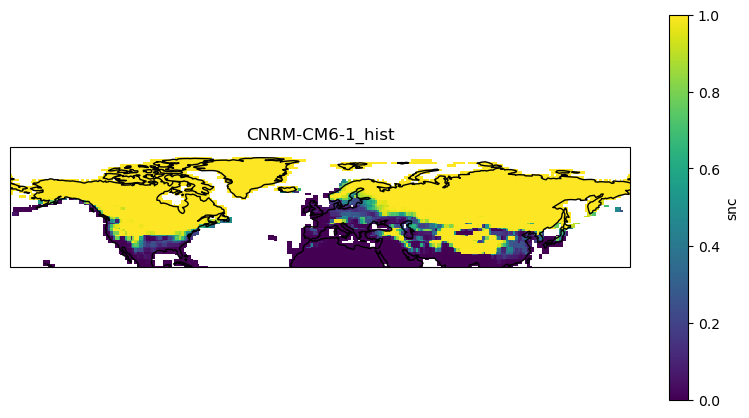

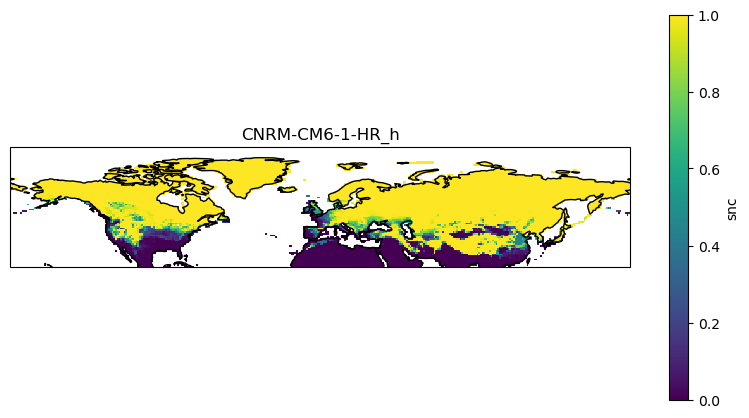

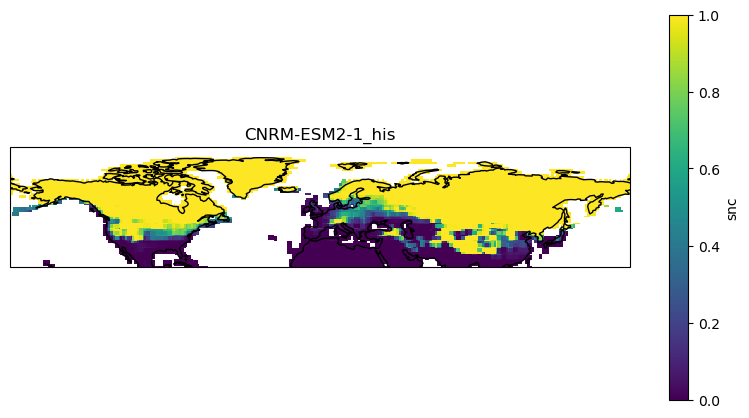

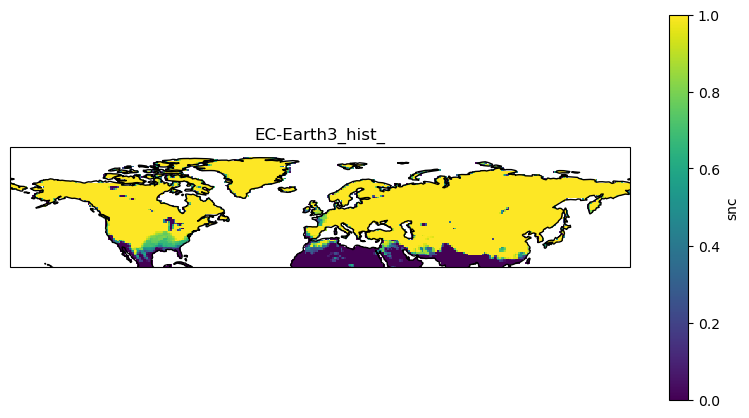

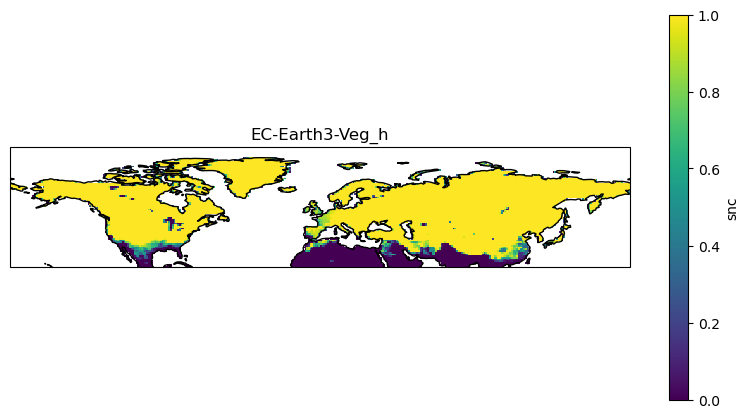

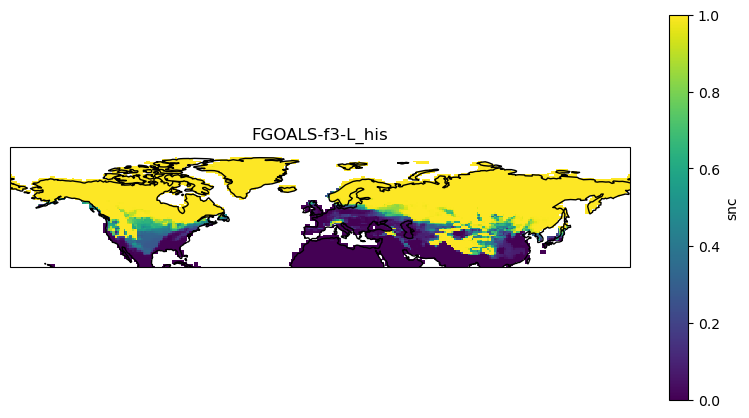

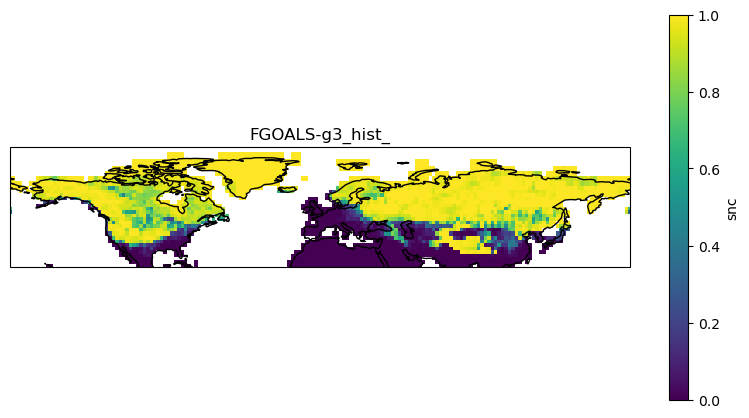

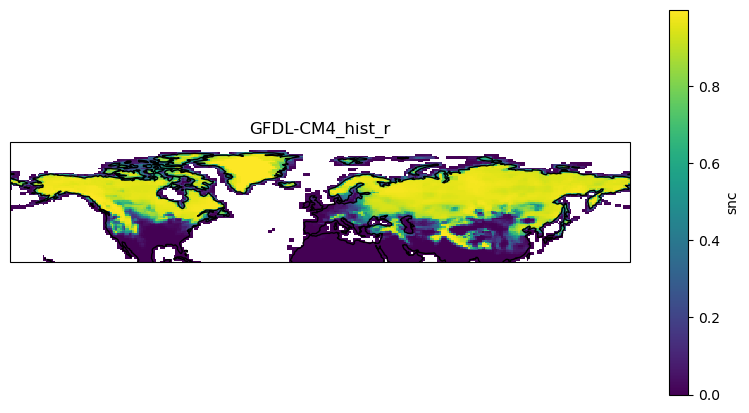

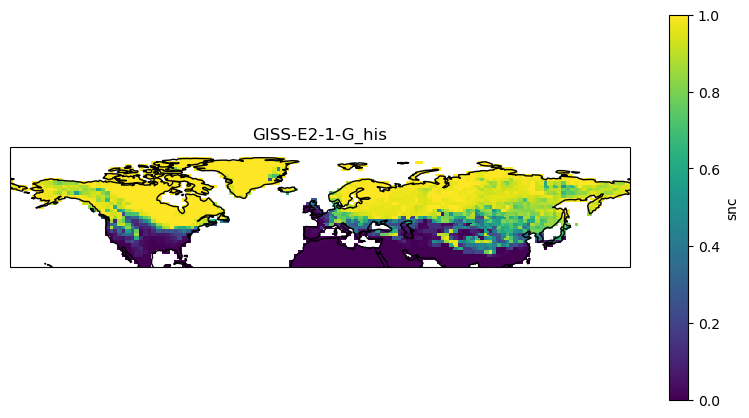

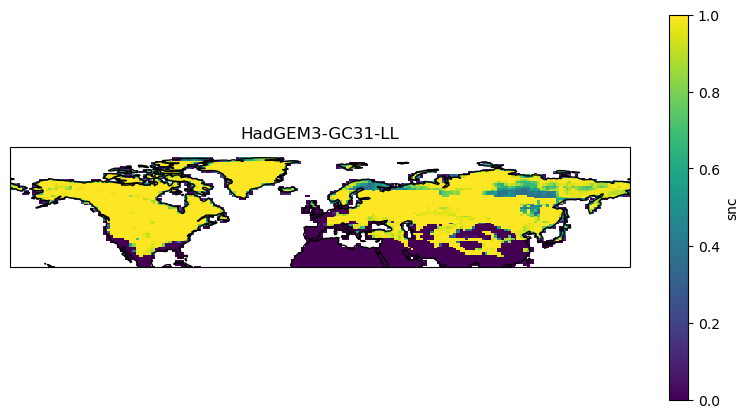

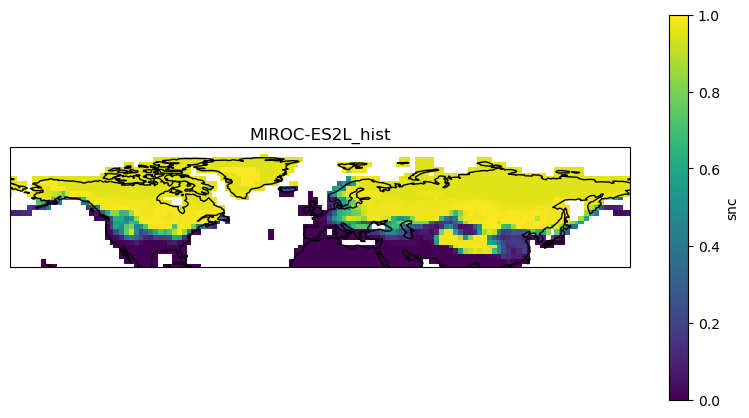

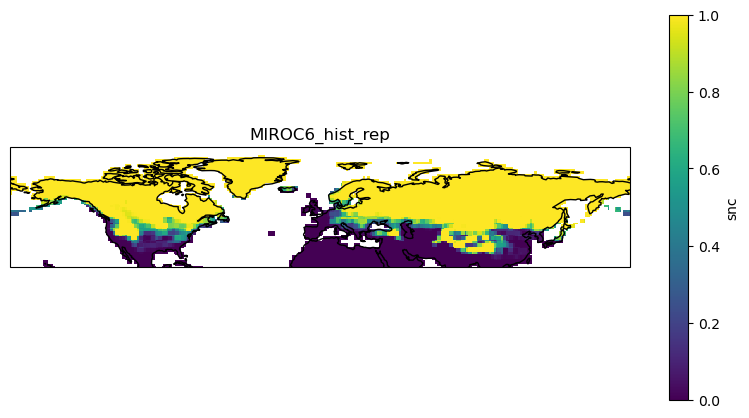

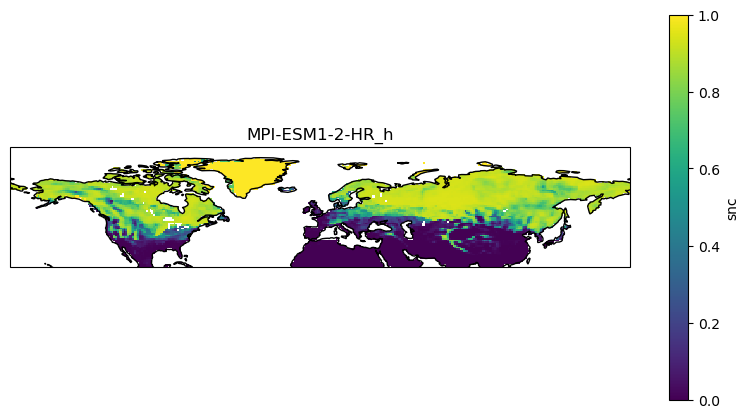

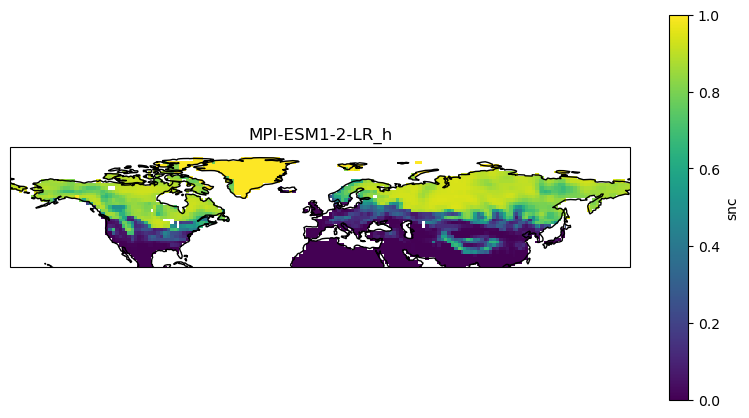

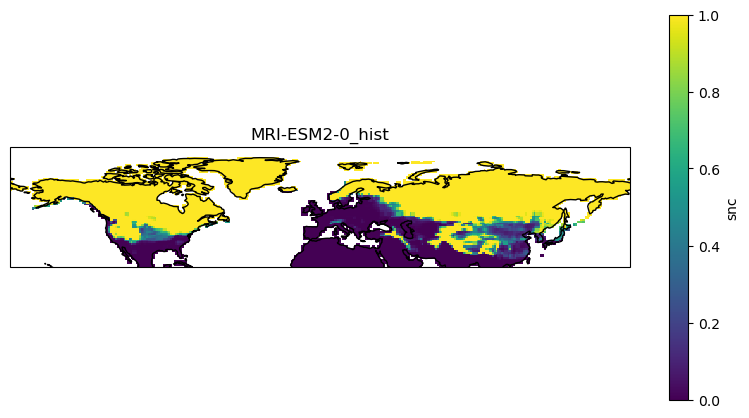

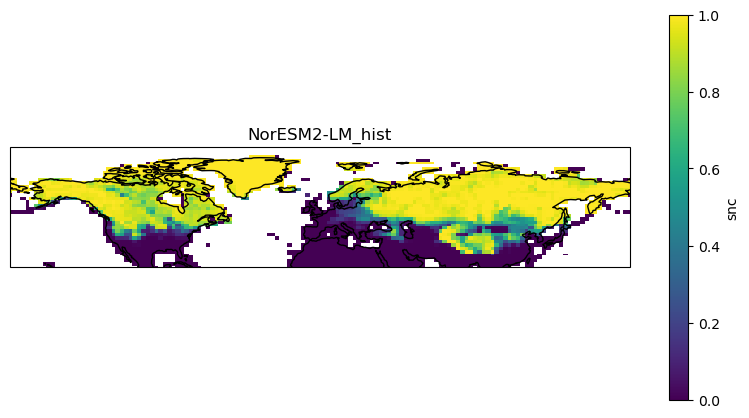

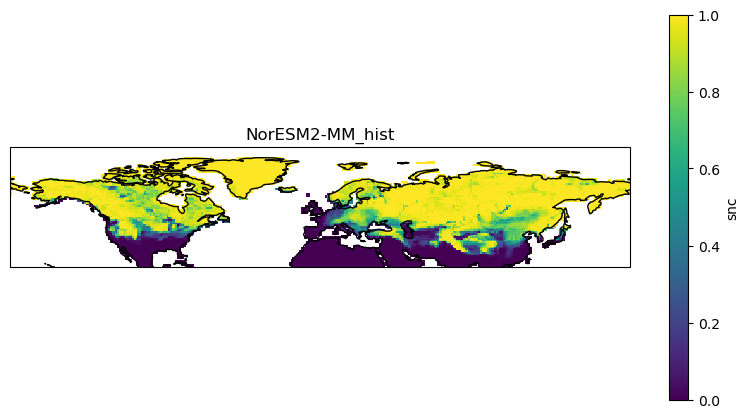

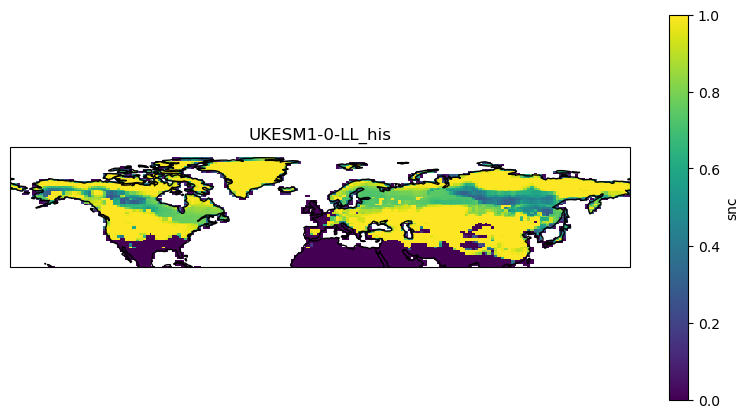

In [206]:
snow_cover_dict = {}

for i, files in enumerate(nc_files):
    model_name = files.split("_")[0]
    
    path_snc = os.path.join("/home/jovyan/private-storage/interp_models_hist_bis/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", files.replace("hist_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", files.replace("hist", "sftlf"))
                                 
    ds_snc, ds_area, ds_sftlf = get_data(path_snc, path_areacella, path_sftlf)
    sftlf = ds_sftlf["sftlf"]
    snc, snow_cover, monthly_mean = extraction_variable_and_monthly_mean(ds_snc)
    areacella = ds_area["cell_area"]
    snow_cover_km2 = snow_surface_calculation(snow_cover, areacella)
    snow_cover_dict[model_name] = snc

    #ax = axes[i]
    plot_snow_cover_initial(snc, title=files[:15])

    #print(snow_cover_km2)
    
    ds_snc.close()
    ds_area.close()

## Moyenne all models

In [207]:
monthly_means = {}

for model, da in snow_cover_dict.items():
    if not np.issubdtype(da.time.dtype, np.datetime64):
        try:
            da = da.convert_calendar('standard', align_on='year')
            da['time'] = da['time'].astype('datetime64[ns]')
        except Exception as e:
            print(f"Erreur conversion temps pour {model} : {e}")
            continue

    # Moyenne mensuelle
    monthly_mean = da.groupby('time.month').mean('time', skipna=True)
    monthly_means[model] = monthly_mean

In [208]:
for model in monthly_means:
    if 'type' in monthly_means[model].coords:
        monthly_means[model] = monthly_means[model].drop_vars('type')

aligned = xr.align(*monthly_means.values(), join='inner')

In [209]:
combined = xr.concat(aligned, dim='model')
combined = combined.assign_coords(model=list(monthly_means.keys()))

In [210]:
combined

<xarray.DataArray 'snc' (model: 25, month: 12, lat: 70, lon: 360)> Size: 30MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * model    (model) <U15 2kB 'IPSL-CM6A-LR' 'BCC-CSM2-MR' ... 'UKESM1-0-LL'

In [211]:
mean_snc = combined.mean(dim="model")

In [212]:
mean_snc

<xarray.DataArray 'snc' (month: 12, lat: 70, lon: 360)> Size: 1MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [213]:
path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", "MRI-ESM2-0_sftlf_reprojete.nc")

In [214]:
sftlf = xr.open_dataset(path_sftlf)
sftlf = sftlf["sftlf"]

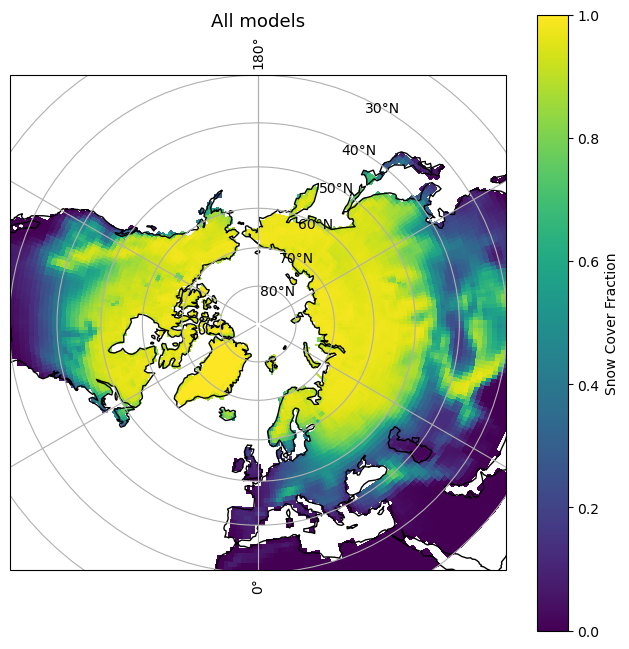

In [215]:
spring = mean_snc.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)

masked_spring = spring.where(sftlf > 50)

# carte polaire
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=0,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={'label': 'Snow Cover Fraction'}
)

ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("All models", fontsize=13)
plt.show()

In [216]:
mean_snc_binary = (mean_snc > 0.1).astype(int)
spring_bin = mean_snc_binary.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)
masked_spring_bin = spring_bin.where(sftlf > 50)

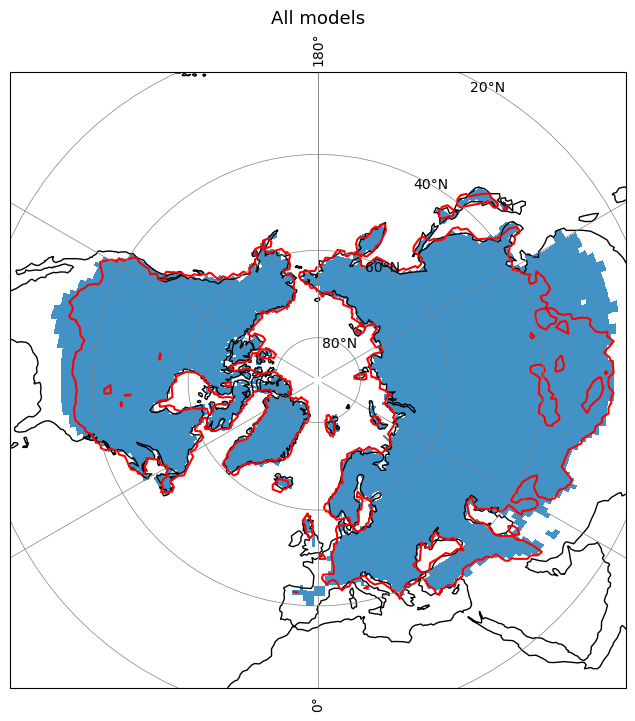

In [217]:
cmap = mcolors.ListedColormap(['white', '#4292C6'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring_bin.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

ax.contour(
    djf_snow_reference['lon'],  # ou djf_snow_reference.longitude selon ton DataArray
    djf_snow_reference['lat'],  # ou djf_snow_reference.latitude
    djf_snow_reference,         # DataArray contenant les données de référence
    levels=[0.1],               # seuil pour le contour (neige présente)
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree()
)

ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='-')

plt.title("All models", fontsize=13)
#plt.savefig("all_models.png")
plt.show()

In [220]:
def surface_calculation(masked_spring_bin, areacella):
    area_km2 = areacella * 1e-6 #je convertis en km2
    snow_cover_km2 = (masked_spring_bin * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
    return snow_cover_km2

In [221]:
snow_cover_km2 = surface_calculation(masked_spring_bin, areacella)
snow_cover_km2

<xarray.DataArray ()> Size: 8B
array(58383494.67674013)
Coordinates:
    type     |S4 4B b'land'

## Moyenne exclusion "mauvais" modèles

In [222]:
excluded_models = ["EC-Earth3", "EC-Earth3-Veg", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR"]

filtered_nc_files = [f for f in nc_files if not any(model in f for model in excluded_models)]

La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.


/tmp/ipykernel_83/1381132720.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


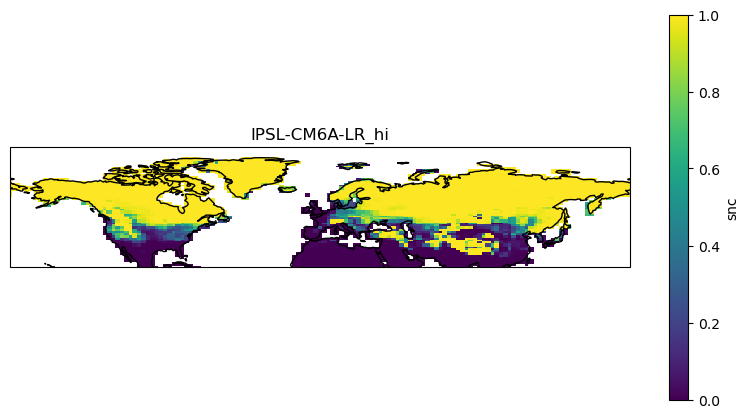

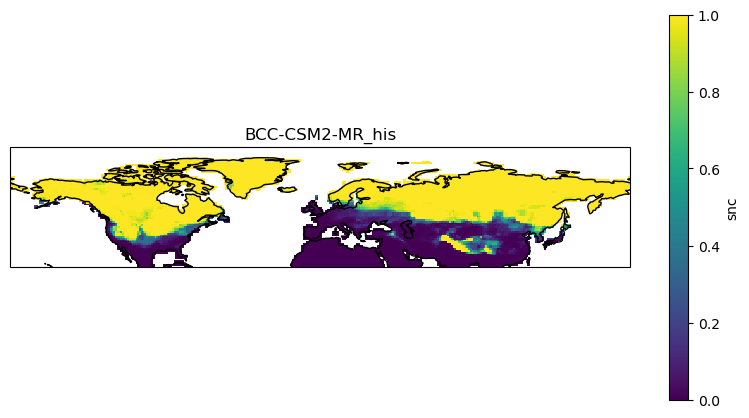

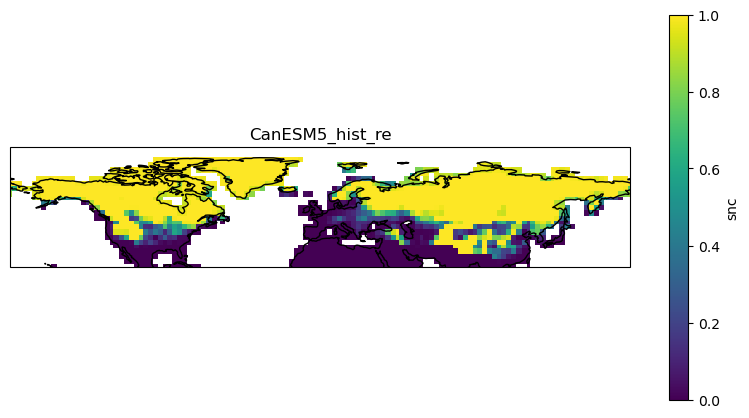

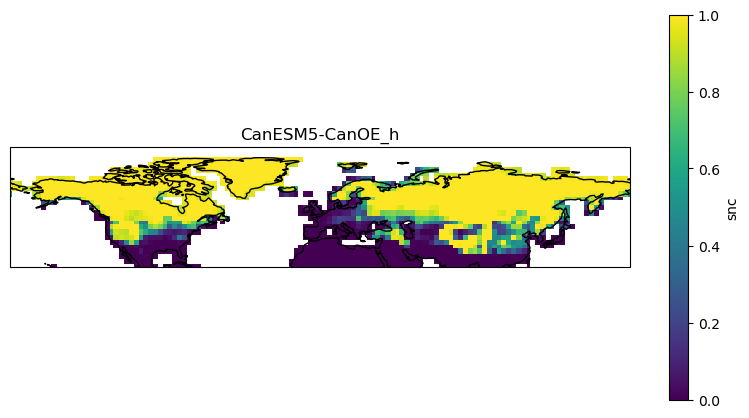

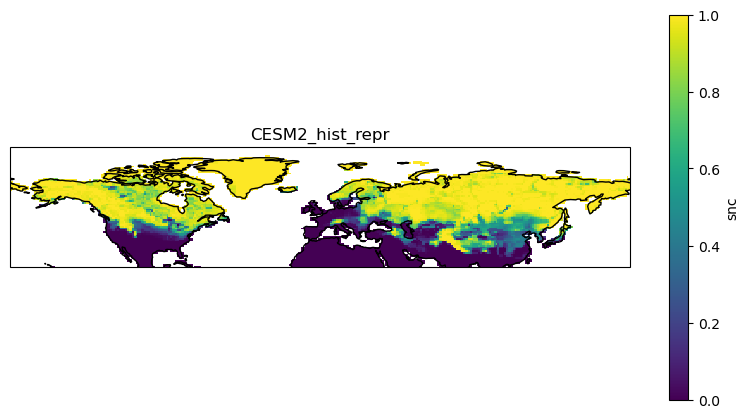

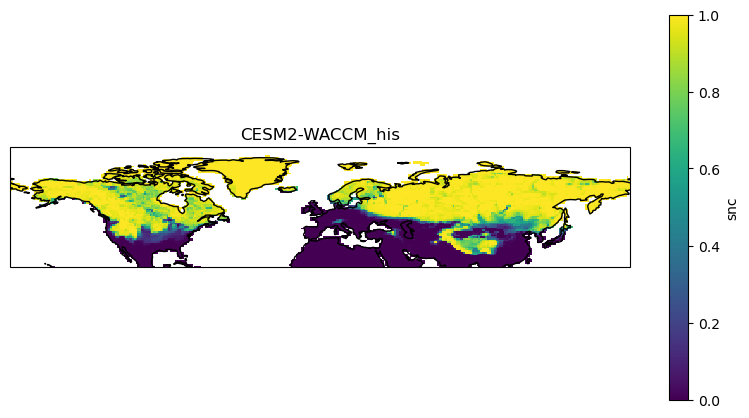

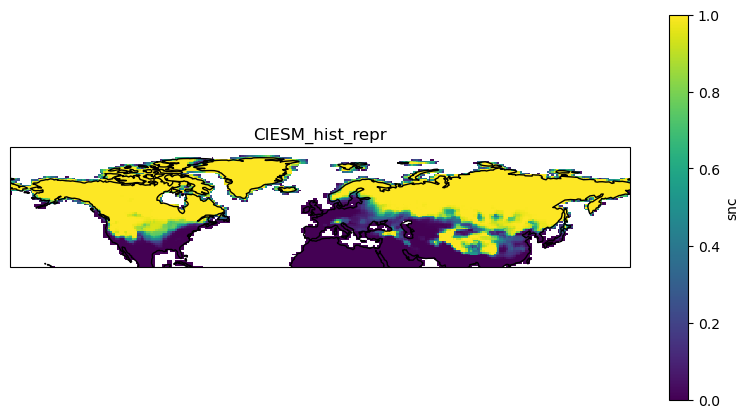

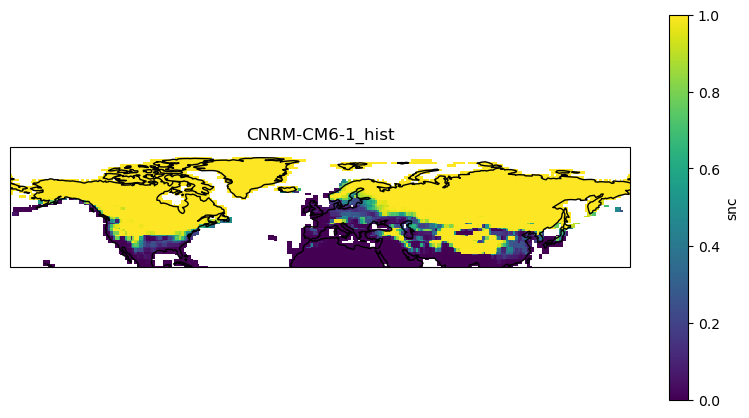

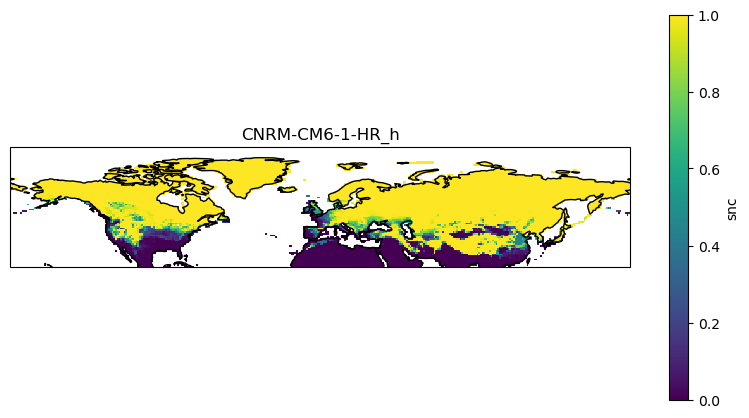

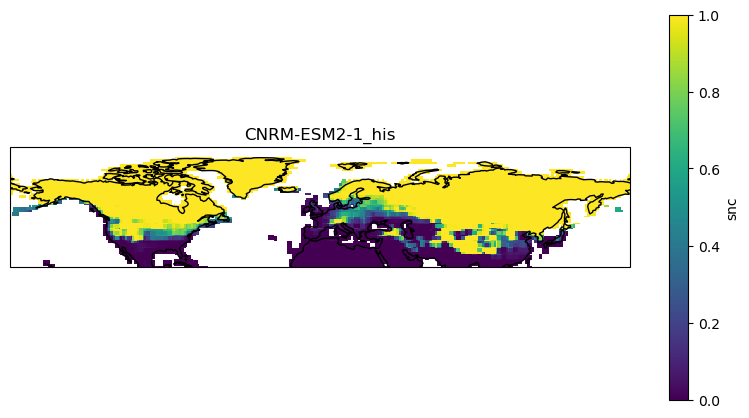

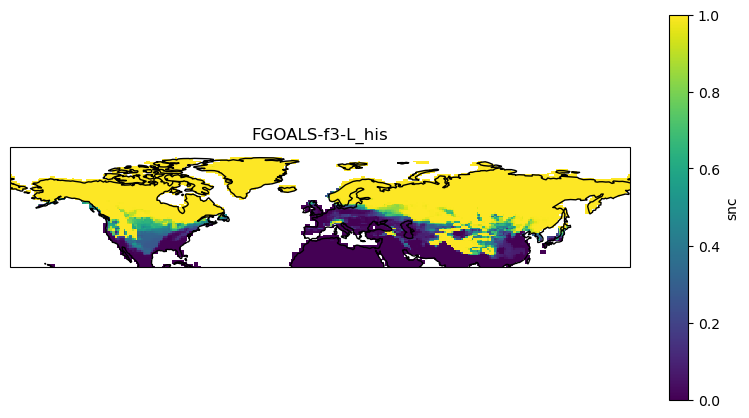

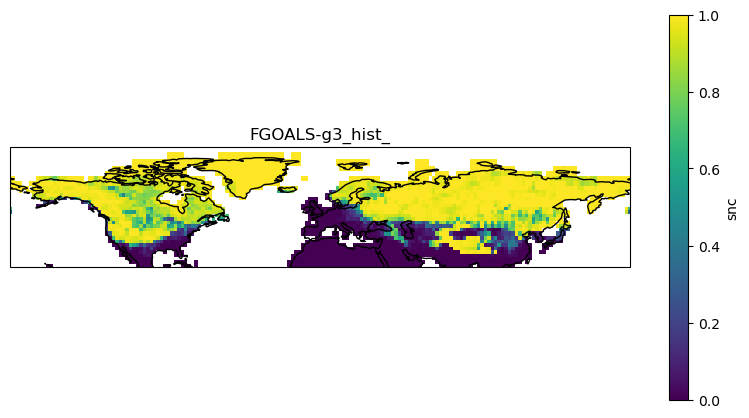

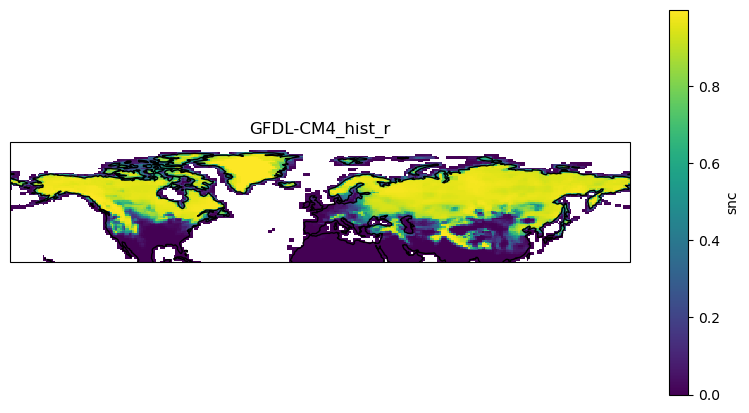

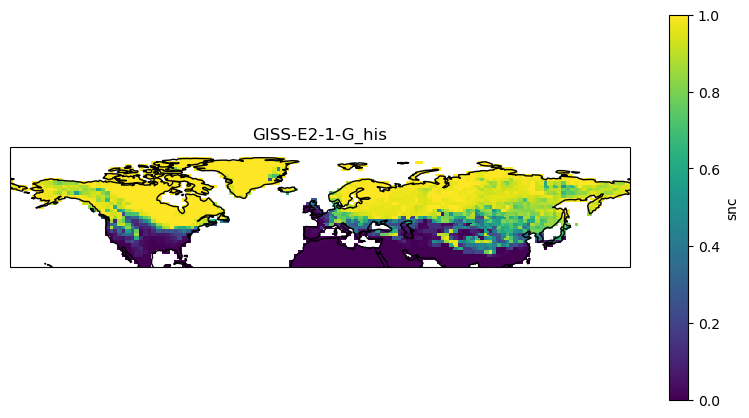

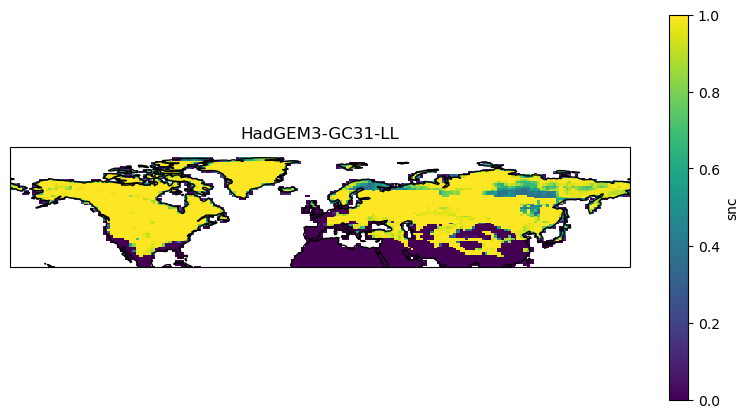

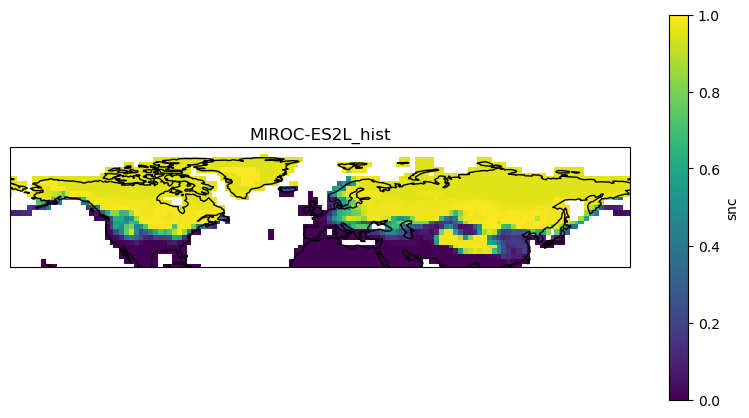

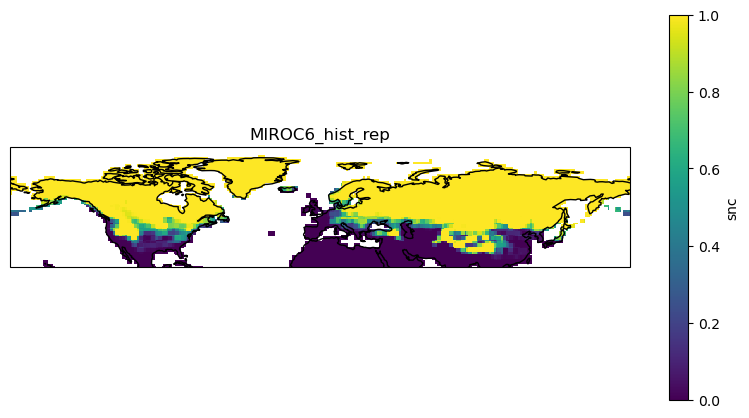

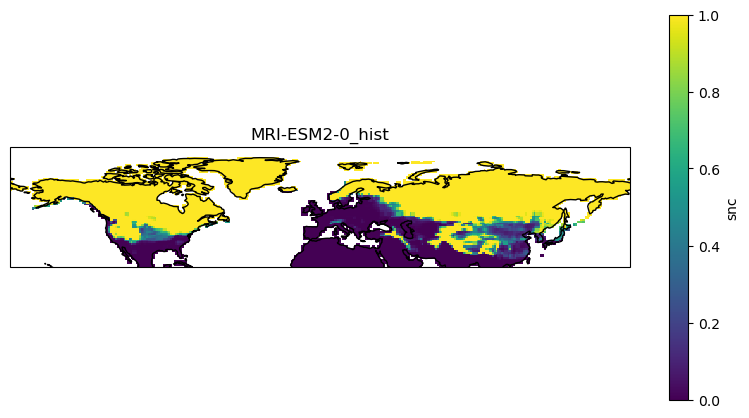

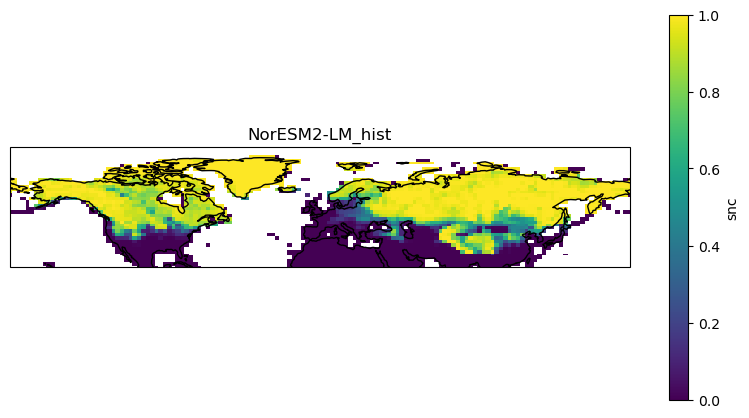

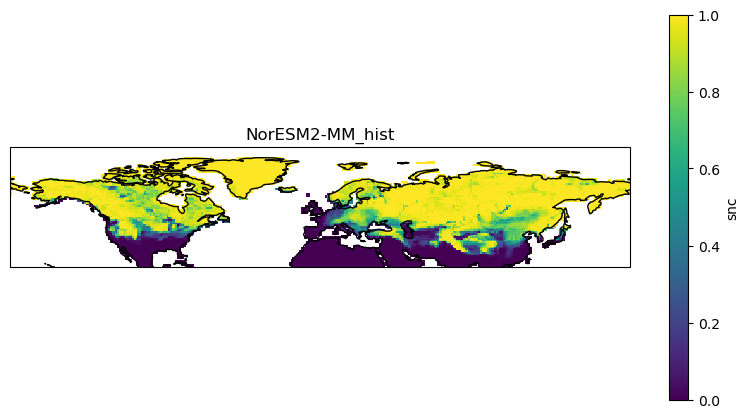

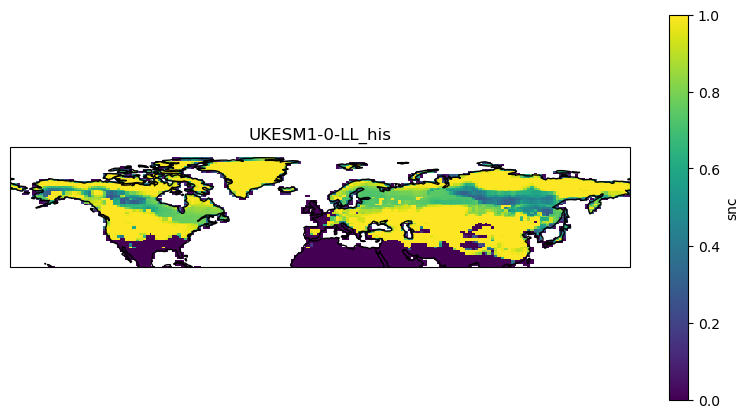

In [223]:
snow_cover_dict_exclusion = {}

for i, files in enumerate(filtered_nc_files):
    model_name = files.split("_")[0]
    
    path_snc = os.path.join("/home/jovyan/private-storage/interp_models_hist_bis/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", files.replace("hist_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", files.replace("hist", "sftlf"))
                                 
    ds_snc, ds_area, ds_sftlf = get_data(path_snc, path_areacella, path_sftlf)
    sftlf = ds_sftlf["sftlf"]
    snc, snow_cover, monthly_mean = extraction_variable_and_monthly_mean(ds_snc)
    areacella = ds_area["cell_area"]
    snow_cover_km2 = snow_surface_calculation(snow_cover, areacella)
    snow_cover_dict_exclusion[model_name] = snc

    #ax = axes[i]
    plot_snow_cover_initial(snc, title=files[:15])

    #print(snow_cover_km2)
    
    ds_snc.close()
    ds_area.close()

In [224]:
monthly_means_exclusion = {}

for model, da in snow_cover_dict_exclusion.items():
    if not np.issubdtype(da.time.dtype, np.datetime64):
        try:
            da = da.convert_calendar('standard', align_on='year')
            da['time'] = da['time'].astype('datetime64[ns]')
        except Exception as e:
            print(f"Erreur conversion temps pour {model} : {e}")
            continue

    # Moyenne mensuelle
    monthly_mean_exclusion = da.groupby('time.month').mean('time', skipna=True)
    monthly_means_exclusion[model] = monthly_mean_exclusion

In [225]:
for model in monthly_means_exclusion:
    if 'type' in monthly_means_exclusion[model].coords:
        monthly_means_exclusion[model] = monthly_means_exclusion[model].drop_vars('type')

In [226]:
aligned_exclusion = xr.align(*monthly_means_exclusion.values(), join='inner')
combined_exclusion = xr.concat(aligned_exclusion, dim='model')
combined_exclusion['model'] = list(monthly_means_exclusion.keys())

In [227]:
mean_snc_exclusion = combined_exclusion.mean(dim="model")

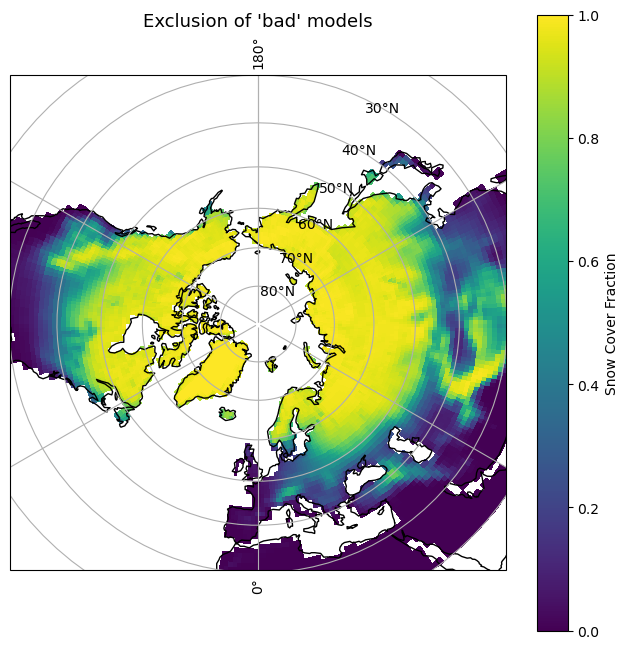

In [228]:
spring_exclusion = mean_snc_exclusion.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)

masked_spring_exclusion = spring_exclusion.where(sftlf > 50)

# Carte polaire
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring_exclusion.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=0,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={'label': 'Snow Cover Fraction'}
)

ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("Exclusion of 'bad' models", fontsize=13)
#plt.savefig("exclusion_bad_models_ref.png")
plt.show()

In [229]:
mean_snc_pondere_binary = (mean_snc_exclusion > 0.1).astype(int)
spring_bin = mean_snc_pondere_binary.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)
masked_spring_bin = spring_bin.where(sftlf > 50)

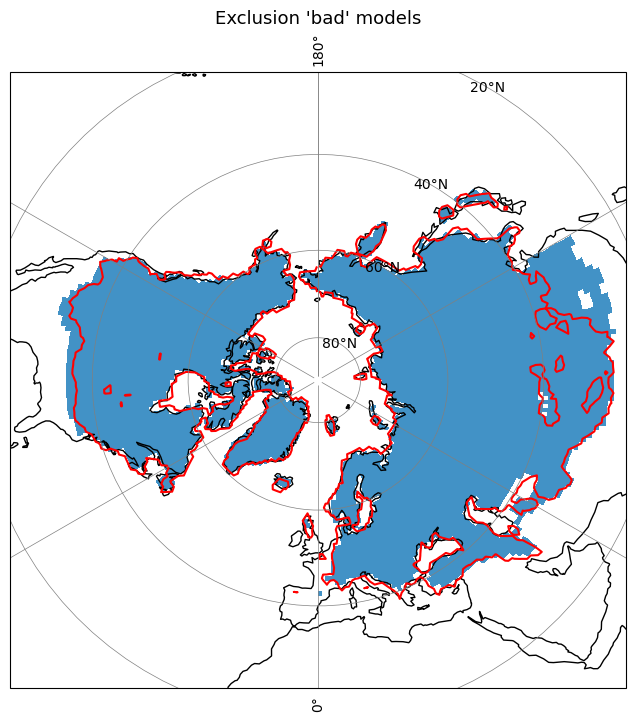

In [230]:
cmap = mcolors.ListedColormap(['white', '#4292C6'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring_bin.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

ax.contour(
    djf_snow_reference['lon'],  
    djf_snow_reference['lat'],  
    djf_snow_reference,         
    levels=[0.1],               # seuil pour le contour (neige présente)
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree()
)

ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='-')

plt.title("Exclusion 'bad' models", fontsize=13)
plt.savefig("exclusion_bad_models.png")
plt.show()

In [231]:
def surface_calculation(masked_spring_bin, areacella):
    area_km2 = areacella * 1e-6 #je convertis en km2
    snow_cover_km2 = (masked_spring_bin * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
    return snow_cover_km2

In [232]:
path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", "MRI-ESM2-0_gridarea_hist_recalcule.nc")

In [233]:
snow_cover_km2 = surface_calculation(masked_spring_bin, areacella)

In [234]:
snow_cover_km2

<xarray.DataArray ()> Size: 8B
array(55898936.83723455)
Coordinates:
    type     |S4 4B b'land'

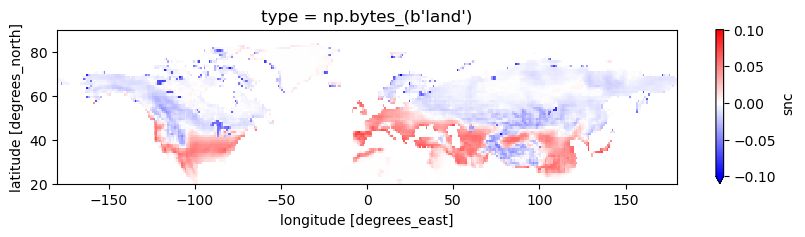

In [172]:
diff = masked_spring - masked_spring_exclusion
plt.figure(figsize=(10, 2))
diff.plot(cmap='bwr', vmin=-0.1, vmax=0.1)

In [173]:
combined_exclusion

<xarray.DataArray 'snc' (model: 21, month: 12, lat: 70, lon: 360)> Size: 25MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * model    (model) <U15 1kB 'IPSL-CM6A-LR' 'BCC-CSM2-MR' ... 'UKESM1-0-LL'

## Exponential scoring

In [235]:
scores_modeles = pd.read_csv("~/private-storage/fichiers_csv/scores_modeles.csv", index_col=0)
scores_modeles

Erreur_moyenne  Scores_exp  Scores_gauss
MRI_ESM2_0         1.266978e+06    1.000000      1.000000
FGOALS_f3_L        1.609116e+06    0.968784      0.991986
NorESM2_LM         1.851120e+06    0.947293      0.976818
NorESM2_MM         1.869009e+06    0.945724      0.975395
IPSL_CM6A_LR       1.927405e+06    0.940619      0.970464
CIESM              1.962490e+06    0.937564      0.967296
CanESM5            2.056824e+06    0.929402      0.958024
CanESM5_CanOE      2.183057e+06    0.918590      0.943948
CESM2_WACCM        2.201268e+06    0.917041      0.941764
BCC_CSM2_MR        2.286914e+06    0.909790      0.930991
CESM2              2.395764e+06    0.900656      0.916144
FGOALS_g3          2.430790e+06    0.897737      0.911101
CNRM_ESM2_1        2.649459e+06    0.879724      0.876889
MIROC6             2.782514e+06    0.868940      0.853953
MIROC_ES2L         2.791986e+06    0.868178      0.852264
UKESM1_0_LL        3.097610e+06    0.843928      0.794253
CNRM_CM6_1_HR      3.176870e+06    0.837750      0.778231
CNRM_CM6_1         3.299169e+06    0.828307      0.752864
GISS_E2_1_G        3.367435e+06    0.823082      0.738404
GFDL_CM4           4.964078e+06    0.709852      0.390808
HadGEM3_GC31_LL    5.206403e+06    0.694085      0.344129
MPI_ESM1_2_LR      9.418989e+06    0.469709      0.010379
MPI_ESM1_2_HR      9.600430e+06    0.461875      0.008450
EC_Earth3_Veg      1.154588e+07    0.385663      0.000701
EC_Earth3          1.205517e+07    0.367879      0.000335

In [236]:
combined

<xarray.DataArray 'snc' (model: 25, month: 12, lat: 70, lon: 360)> Size: 30MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * model    (model) <U15 2kB 'IPSL-CM6A-LR' 'BCC-CSM2-MR' ... 'UKESM1-0-LL'

In [237]:
weights = xr.DataArray(
    scores_modeles["Scores_exp"],
    coords = {"modele_x": scores_modeles.index},
    dims="modele_x"
)

In [238]:
weights = weights.rename({"modele_x": "model"})
weights = weights.assign_coords(
    model=[m.replace("_", "-") for m in weights.model.values]
)

In [239]:
combined, weights = xr.align(combined, weights, join="inner")
weighted = combined * weights

In [240]:
mean_snc_pondere_exp = (weighted).sum(dim="model") / weights.sum(dim="model")

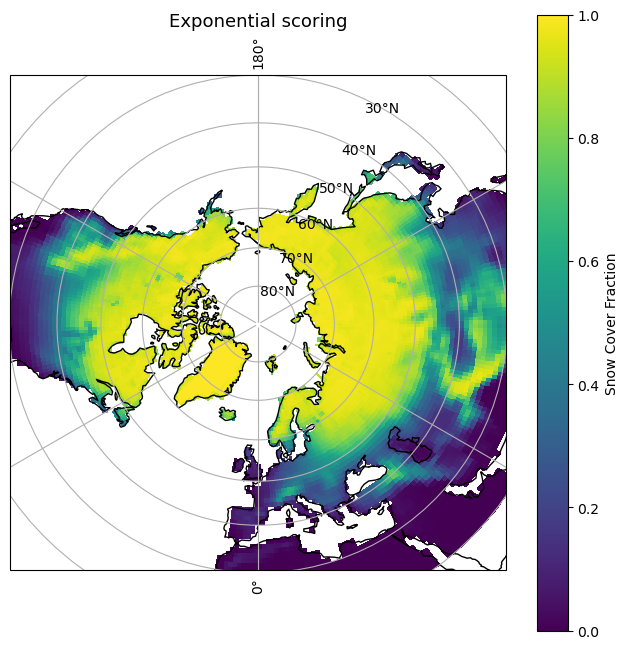

In [241]:
spring_exp = mean_snc_pondere_exp.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)

masked_spring_exp = spring_exp.where(sftlf > 50)

# carte polaire
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=0,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={'label': 'Snow Cover Fraction'}
)

ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("Exponential scoring", fontsize=13)
#plt.savefig("exponential_scoring_ref.png")
plt.show()

In [242]:
mean_snc_pondere_exp_binary = (mean_snc_pondere_exp > 0.1).astype(int)
spring_exp_bin = mean_snc_pondere_exp_binary.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)
masked_spring_exp_bin = spring_exp_bin.where(sftlf > 50)

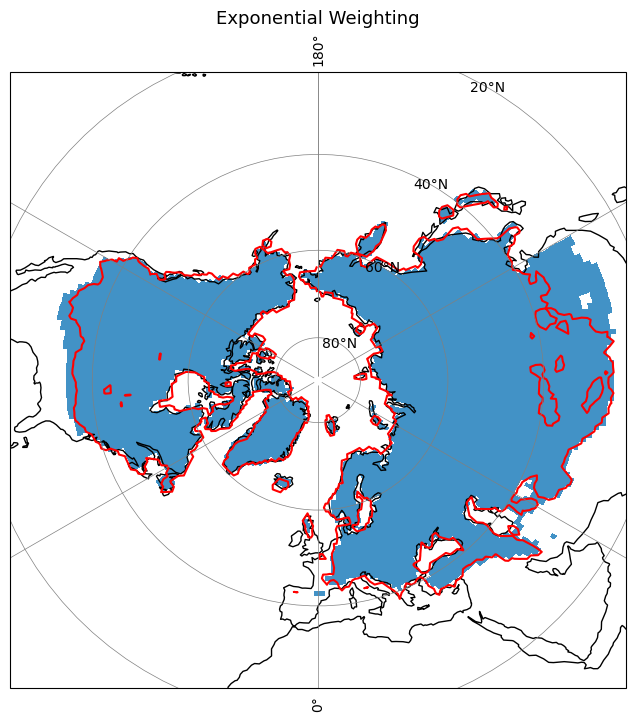

In [243]:
cmap = mcolors.ListedColormap(['white', '#4292C6'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring_exp_bin.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

ax.contour(
    djf_snow_reference['lon'],  # ou djf_snow_reference.longitude selon ton DataArray
    djf_snow_reference['lat'],  # ou djf_snow_reference.latitude
    djf_snow_reference,         # DataArray contenant les données de référence
    levels=[0.1],               # seuil pour le contour (neige présente)
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree()
)

ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='-')

plt.title("Exponential Weighting", fontsize=13)
plt.savefig("exponential.png")
plt.show()

In [244]:
def surface_calculation(masked_spring_exp_bin, areacella):
    area_km2 = areacella * 1e-6 #je convertis en km2
    snow_cover_km2 = (masked_spring_exp_bin * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
    return snow_cover_km2

In [245]:
snow_cover_km2 = surface_calculation(masked_spring_exp_bin, areacella)
snow_cover_km2

<xarray.DataArray ()> Size: 8B
array(56577870.92519921)
Coordinates:
    type     |S4 4B b'land'

## Gaussian scoring

In [246]:
weights = xr.DataArray(
    scores_modeles["Scores_gauss"],
    coords = {"modele_x": scores_modeles.index},
    dims="modele_x"
)

In [247]:
weights = weights.rename({"modele_x": "model"})
weights = weights.assign_coords(
    model=[m.replace("_", "-") for m in weights.model.values]
)

In [248]:
combined, weights = xr.align(combined, weights, join="inner")
weighted = combined * weights

In [249]:
mean_snc_pondere_gauss = (weighted).sum(dim="model") / weights.sum(dim="model")

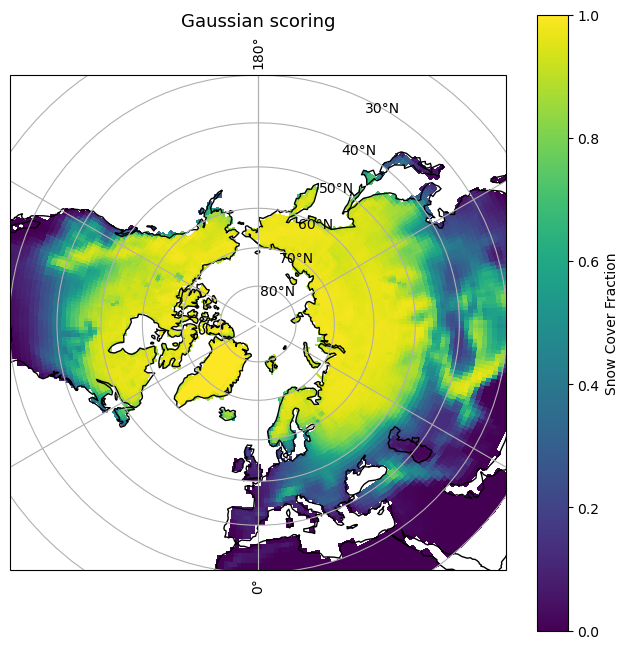

In [250]:
spring_gauss = mean_snc_pondere_gauss.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)

masked_spring_gauss = spring_gauss.where(sftlf > 50)

# carte polaire
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=0,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={'label': 'Snow Cover Fraction'}
)

ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("Gaussian scoring", fontsize=13)
#plt.savefig("exponential_scoring_ref.png")
plt.show()

In [251]:
mean_snc_pondere_gauss_binary = (mean_snc_pondere_gauss > 0.1).astype(int)
spring_gauss_bin = mean_snc_pondere_gauss_binary.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)
masked_spring_gauss_bin = spring_gauss_bin.where(sftlf > 50)

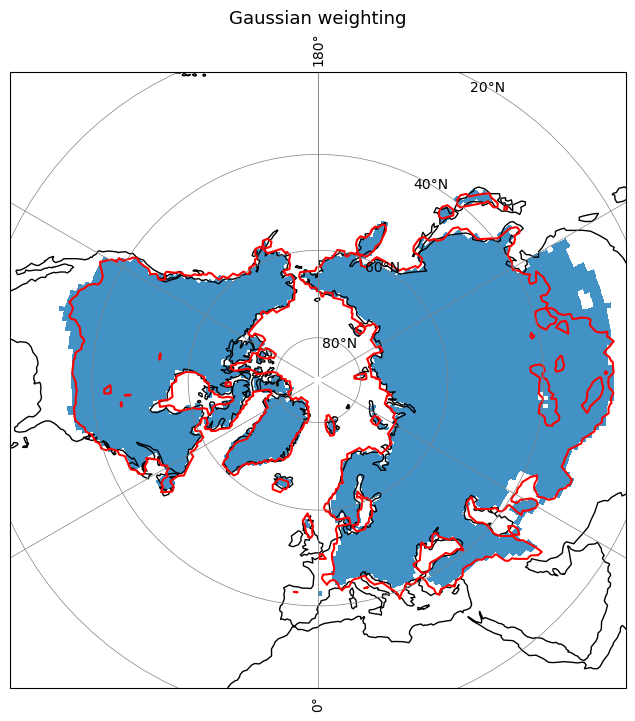

In [255]:
cmap = mcolors.ListedColormap(['white', '#4292C6'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring_gauss_bin.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

ax.contour(
    djf_snow_reference['lon'],  
    djf_snow_reference['lat'],  
    djf_snow_reference,         
    levels=[0.1],               
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree()
)

ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='-')

plt.title("Gaussian weighting", fontsize=13)
plt.savefig("gaussian.png")
plt.show()

In [253]:
def surface_calculation(masked_spring_gauss_bin, areacella):
    area_km2 = areacella * 1e-6 #je convertis en km2
    snow_cover_km2 = (masked_spring_gauss_bin * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
    return snow_cover_km2

In [254]:
snow_cover_km2 = surface_calculation(masked_spring_gauss_bin, areacella)
snow_cover_km2

<xarray.DataArray ()> Size: 8B
array(55273997.98399873)
Coordinates:
    type     |S4 4B ...

### Snow cover extent ref

In [256]:
djf_snow_reference_binary = (djf_snow_reference > 0.1).astype(int)
#spring_gauss_bin = mean_snc_pondere_gauss_binary.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)
#masked_spring_gauss_bin = spring_gauss_bin.where(sftlf > 50)

In [258]:
def surface_calculation(djf_snow_reference_binary, areacella):
    area_km2 = areacella * 1e-6 #je convertis en km2
    snow_cover_km2 = (djf_snow_reference_binary * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
    return snow_cover_km2

In [259]:
snow_cover_km2 = surface_calculation(djf_snow_reference_binary, areacella)
snow_cover_km2

<xarray.DataArray ()> Size: 8B
array(53907009.56892844)

### En appliquand un score plus élevé

In [194]:
scores_exp = np.exp(5 * scores_modeles["Scores_exp"])
scores_exp = scores_exp / scores_exp.sum()

In [55]:
weights = xr.DataArray(
    scores_exp,
    coords = {"modele_x": scores_modeles.index},
    dims="modele_x"
)

In [56]:
weights = weights.rename({"modele_x": "model"})
weights = weights.assign_coords(
    model=[m.replace("_", "-") for m in weights.model.values]
)

In [57]:
combined, weights = xr.align(combined, weights, join="inner")
weighted = combined * weights

In [58]:
mean_snc_pondere_exp = (weighted).sum(dim="model") / weights.sum(dim="model")

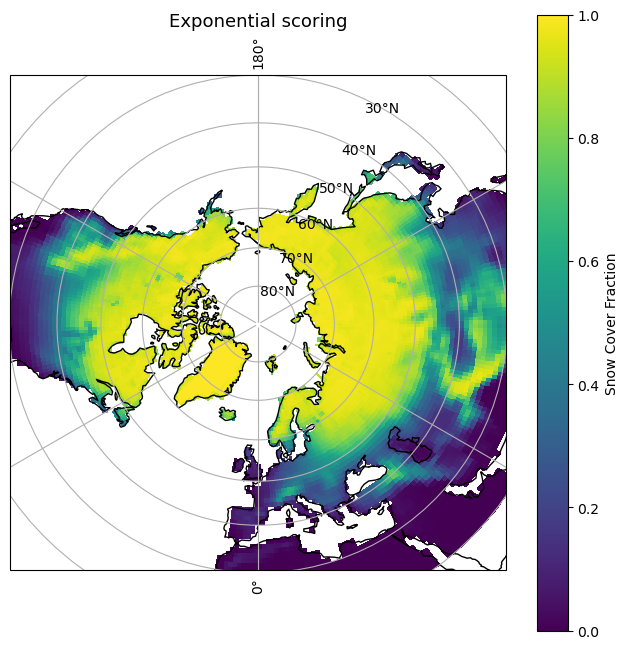

In [60]:
spring_exp = mean_snc_pondere_exp.sel(month=[12, 1, 2]).mean(dim='month', skipna=True)

masked_spring_exp = spring_exp.where(sftlf > 50)

# 3. Carte polaire
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

plot = masked_spring.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=0,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={'label': 'Snow Cover Fraction'}
)

# Mise en page
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)
#ax.set_boundary(plt.Circle((0.5, 0.5), 0.5,transform=ax.transAxes))

plt.title("Exponential scoring", fontsize=13)
#plt.savefig("exponential_scoring_ref.png")
plt.show()

Text(0.5, 1.0, 'Impact of Exponential Weighting')

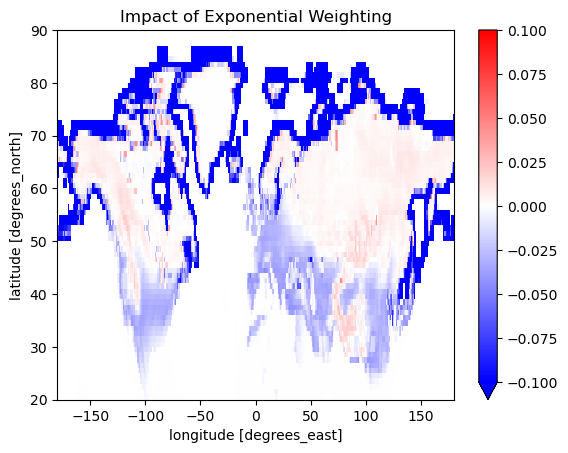

In [43]:
spring_diff = spring_exp - spring
spring_diff.plot(cmap='bwr', vmin=-0.1, vmax=0.1)
plt.title("Impact of Exponential Weighting")

In [44]:
print("Poids totaux :")
print(weights.sum().values)

print("Poids par modèle :")
print(weights.values)

Poids totaux :
20.252171354395525
Poids par modèle :
[0.94061858 0.90978963 0.92940196 0.91859037 0.90065625 0.91704112
 0.93756448 0.82830674 0.83775012 0.87972354 0.36787944 0.38566271
 0.96878351 0.89773684 0.70985205 0.82308185 0.69408504 0.8681776
 0.86894021 0.4618753  0.46970902 1.         0.94729341 0.94572389
 0.84392772]


In [45]:
diff = mean_snc_pondere_exp - mean_snc  # mean_snc = moyenne simple
print(diff.max().item(), diff.min().item())

0.064656837853453 -0.9556720698776446


In [47]:
for m in combined.model.values:
    print(f"{m}: weight = {weights.sel(model=m).values}")

IPSL-CM6A-LR: weight = 0.9406185784827464
BCC-CSM2-MR: weight = 0.90978963312786
CanESM5: weight = 0.929401955444554
CanESM5-CanOE: weight = 0.9185903708195208
CESM2: weight = 0.9006562459556919
CESM2-WACCM: weight = 0.917041117113334
CIESM: weight = 0.9375644777940966
CNRM-CM6-1: weight = 0.828306744491325
CNRM-CM6-1-HR: weight = 0.8377501196580206
CNRM-ESM2-1: weight = 0.8797235405401621
EC-Earth3: weight = 0.3678794411714423
EC-Earth3-Veg: weight = 0.3856627068295119
FGOALS-f3-L: weight = 0.9687835066111872
FGOALS-g3: weight = 0.8977368366236108
GFDL-CM4: weight = 0.7098520491220487
GISS-E2-1-G: weight = 0.8230818470717928
HadGEM3-GC31-LL: weight = 0.6940850407778482
MIROC-ES2L: weight = 0.8681775967229677
MIROC6: weight = 0.8689402087245712
MPI-ESM1-2-HR: weight = 0.4618752951271079
MPI-ESM1-2-LR: weight = 0.4697090179635967
MRI-ESM2-0: weight = 1.0
NorESM2-LM: weight = 0.9472934102667702
NorESM2-MM: weight = 0.9457238939515096
UKESM1-0-LL: weight = 0.8439277200042491


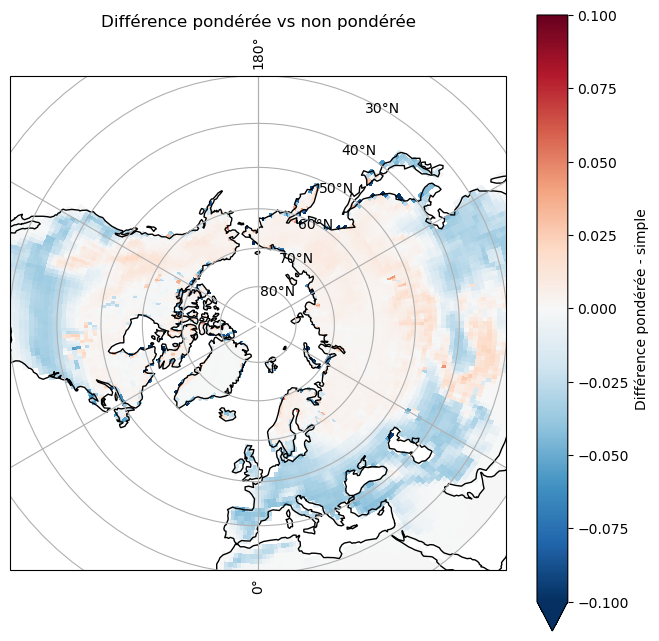

In [49]:
diff = mean_snc_pondere_exp - mean_snc
diff_spring = diff.sel(month=[12, 1, 2]).mean(dim='month')

masked_diff = diff_spring.where(sftlf > 50)

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
masked_diff.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    center=0,
    vmin=-0.1, vmax=0.1,  # étire l'échelle
    cbar_kwargs={'label': 'Différence pondérée - simple'}
)
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("Différence pondérée vs non pondérée")
plt.show()